# Validation against real data

In this notebook, a standard deviation from intrest rate data from the Federal reserve over the period 1970-2010 [4] is estimated and this is passed to our model as the 'sigma intrest rate' parameter and to Drupsteens model as the 'sigma node exposure' parameter. Then, the model results are compared to data of banking defaults from an IMF study [4]

In [117]:
# Imports
import pandas as pd
from scipy.stats import ks_2samp
import os
import matplotlib.pyplot as plt
import numpy as np


In [118]:

directory_path = R'.\Data\Validation'
files_in_directory = os.listdir(directory_path)

print("Files in directory:")
for file in files_in_directory:
    print(file)

    # pd.read_csv('bankruptcy_data.csv')

Files in directory:
300_2000_1_1_3.5699004438176827_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_202402011655.csv
300_2000_1_3.5699004438176827_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201160408.csv
bankrupt1970-2010.CSV.xls
FEDFUNDS.csv


In [119]:
bankruptcy_data = pd.read_csv(directory_path + R'\bankrupt1970-2010.CSV.xls')
bankruptcy_data

,1970,0
0,1971,0
1,1972,0
2,1973,0
3,1974,0
4,1975,0
5,1976,2
6,1977,2
7,1978,0
8,1979,0
9,1980,3


In [120]:
bankruptcy_data = bankruptcy_data.iloc[:, 1]

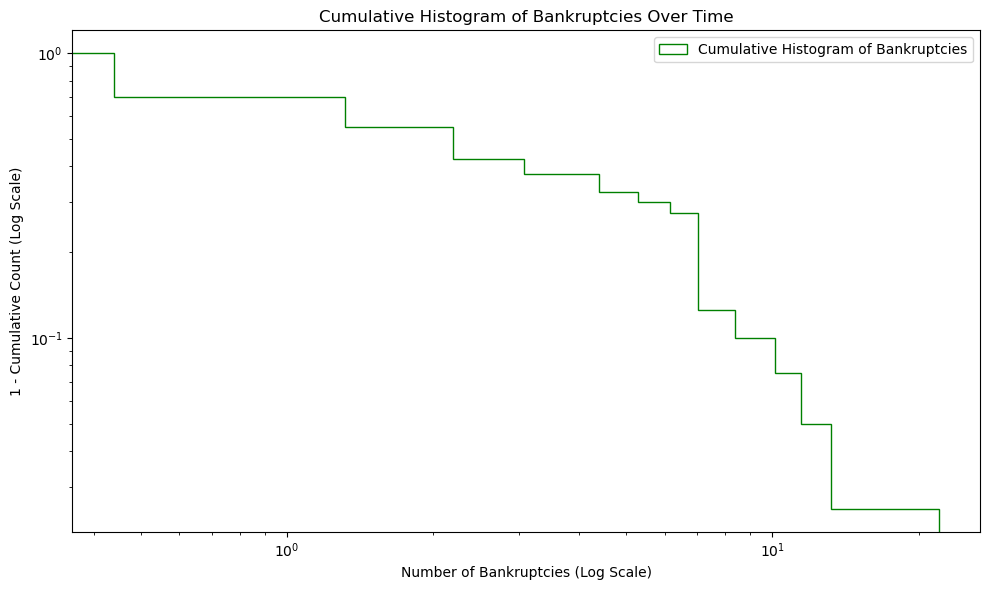

In [121]:
plt.figure(figsize=(10, 6))
plt.hist(bankruptcy_data, bins=50, cumulative=-1, log=True, color='green', label='Cumulative Histogram of Bankruptcies', histtype='step', density=True)
plt.xscale('log')
plt.xlabel('Number of Bankruptcies (Log Scale)')
plt.ylabel('1 - Cumulative Count (Log Scale)')
plt.title('Cumulative Histogram of Bankruptcies Over Time')
plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()

In [122]:
def get_files_with_parameters(directory_path, input_parameters):
    # Read all files in the directory
    
    all_files = os.listdir(directory_path)
    print('all files in directory: ', all_files)

    # List to hold DataFrames of files that match the input parameters
    matching_files_data = []

    for filename in all_files:
        # Split the filename on the first underscore to drop the initial number sequence
        parts = filename.split('_', 1)
        if len(parts) == 2:
            # Split the parameters part on the last underscore to drop the timestamp
            prefix, parameters_with_timestamp = parts
            parameters = '_'.join(parameters_with_timestamp.split('_')[:-1])
            
            # Check if the file parameters match the input parameters
            if input_parameters in parameters:
                # Construct the full path to the file
                file_path = os.path.join(directory_path, filename)
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_path)
                # Add the DataFrame to the list
                matching_files_data.append(df)

    return matching_files_data

def select_variable_given_list_of_dfs(selected_dfs: list, variable_name: str):
    # List to hold lists of the selected variable from each DataFrame
    list_of_lists = []

    for df in selected_dfs:
        # Check if the variable_name column exists to avoid KeyError
        if variable_name in df.columns:
            # Extract the variable column
            variable_data = df[variable_name]
            
            # Convert each item in the column to a list of floats
            for item in variable_data:
                if isinstance(item, str):  # If item is a string, convert from string representation
                    floats_list = convert_string_representation_to_list(item)
                elif isinstance(item, list):  # If item is already a list, use it as is
                    floats_list = item
                elif isinstance(item, float) or isinstance(item, int):  # If item is a number, place it in a list
                    floats_list = [item]
                else:
                    raise TypeError(f"Unexpected type for '{variable_name}': {type(item)}")
                list_of_lists.append(floats_list)
        else:
            print(f"The variable '{variable_name}' is not in the DataFrame.")

    return list_of_lists

def convert_string_representation_to_list(item):
    if isinstance(item, str):
        # Remove the square brackets and split the string on commas
        clean_string = item.strip('[]')
        # Split the string on commas and convert each part to float
        return [float(s) for s in clean_string.split(',')]
    elif isinstance(item, float) or isinstance(item, int):
        # If the item is a number, return it in a list
        return [item]
    else:
        # If the item is a list, assume it is already in the correct format
        return item

def adjust_bankrupt_agents(num_bankrupt_agents, diff_bankrupt_agents):
    # Assumes num_bankrupt_agents and diff_bankrupt_agents are lists of floats
    return [num_bankrupt_agents[0]] + diff_bankrupt_agents[:-1]

In [123]:
path = R'.\Data\Validation'

input_parameters_model = 'divide exposure singly_intrest_rate'
input_parameters_paper = 'random link logic_exposure'

selected_files_model = get_files_with_parameters(path, input_parameters_model)
selected_files_paper = get_files_with_parameters(path, input_parameters_paper)

data_plot_2_our_model_diff_agents = select_variable_given_list_of_dfs(selected_files_model, 'Abs Difference of Bankrupt Agents Over Time')
data_plot_2_paper_diff_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Abs Difference of Bankrupt Agents Over Time')
data_plot_2_our_model_num_agents = select_variable_given_list_of_dfs(selected_files_model, 'Number of Bankrupt Agents Over Time')
data_plot_2_paper_num_agents = select_variable_given_list_of_dfs(selected_files_paper, 'Number of Bankrupt Agents Over Time')

adjusted_model_data = []
for num_agents_series, diff_agents_series in zip(data_plot_2_our_model_num_agents, data_plot_2_our_model_diff_agents):
    # Convert each item in the Series of strings into a list of floats
    list_of_num_lists = [convert_string_representation_to_list(num_str) for num_str in num_agents_series]
    list_of_diff_lists = [convert_string_representation_to_list(diff_str) for diff_str in diff_agents_series]
    
    # Combine the lists of numbers and differences into adjusted data
    for num_list, diff_list in zip(list_of_num_lists, list_of_diff_lists):
        adjusted_data = adjust_bankrupt_agents(num_list, diff_list)
        adjusted_model_data.extend(adjusted_data)  # Use extend to add items to the flat list

adjusted_paper_data = []
for num_agents_series, diff_agents_series in zip(data_plot_2_paper_num_agents, data_plot_2_paper_diff_agents):
    # Convert each item in the Series of strings into a list of floats
    list_of_num_lists = [convert_string_representation_to_list(num_str) for num_str in num_agents_series]
    list_of_diff_lists = [convert_string_representation_to_list(diff_str) for diff_str in diff_agents_series]
    
    # Combine the lists of numbers and differences into adjusted data
    for num_list, diff_list in zip(list_of_num_lists, list_of_diff_lists):
        adjusted_data = adjust_bankrupt_agents(num_list, diff_list)
        adjusted_paper_data.extend(adjusted_data)  # Use extend to add items to the flat list

all files in directory:  ['300_2000_1_1_3.5699004438176827_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_202402011655.csv', '300_2000_1_3.5699004438176827_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201160408.csv', 'bankrupt1970-2010.CSV.xls', 'FEDFUNDS.csv']
all files in directory:  ['300_2000_1_1_3.5699004438176827_5_1_3_400_hard cutoff_divide exposure singly_intrest_rate_202402011655.csv', '300_2000_1_3.5699004438176827_1_5_1_3_400_hard cutoff_random link logic_exposure_20240201160408.csv', 'bankrupt1970-2010.CSV.xls', 'FEDFUNDS.csv']


In [124]:
adjusted_paper_data

[nan,
 17.0,
 42.0,
 72.0,
 105.0,
 140.0,
 171.0,
 199.0,
 224.0,
 250.0,
 281.0,
 305.0,
 340.0,
 375.0,
 408.0,
 435.0,
 473.0,
 498.0,
 523.0,
 543.0,
 575.0,
 610.0,
 652.0,
 693.0,
 733.0,
 763.0,
 792.0,
 817.0,
 842.0,
 865.0,
 899.0,
 938.0,
 968.0,
 1008.0,
 1046.0,
 1090.0,
 1123.0,
 1149.0,
 1191.0,
 1220.0,
 1242.0,
 1267.0,
 1289.0,
 1319.0,
 1358.0,
 1398.0,
 1434.0,
 1460.0,
 1487.0,
 1516.0,
 1543.0,
 1579.0,
 1607.0,
 1635.0,
 1666.0,
 1696.0,
 1724.0,
 1753.0,
 1775.0,
 1810.0,
 1850.0,
 1875.0,
 1907.0,
 1940.0,
 1970.0,
 1998.0,
 2028.0,
 2062.0,
 2092.0,
 2121.0,
 2161.0,
 2193.0,
 2228.0,
 2267.0,
 2296.0,
 2336.0,
 2368.0,
 2400.0,
 2436.0,
 2466.0,
 2487.0,
 2519.0,
 2548.0,
 2587.0,
 2622.0,
 2657.0,
 2687.0,
 2727.0,
 2758.0,
 2787.0,
 2814.0,
 2850.0,
 2880.0,
 2913.0,
 2945.0,
 2985.0,
 3018.0,
 3054.0,
 3090.0,
 3126.0,
 3161.0,
 3198.0,
 3229.0,
 3266.0,
 3293.0,
 3319.0,
 3354.0,
 3396.0,
 3430.0,
 3460.0,
 3489.0,
 3528.0,
 3572.0,
 3614.0,
 3643.0,
 36

In [125]:
adjusted_data

[64319.0]

KS Test Result (Real vs Our Model): KstestResult(statistic=0.99950002499875, pvalue=1.815355151065231e-132, statistic_location=22.0, statistic_sign=1)
Real vs Our Model: Reject H0. There is a significant difference between the distributions (p = 0.000) at an alpha level of 0.05.
KS Test Result (Real vs Drupsteen Model): KstestResult(statistic=0.999750012499375, pvalue=1.6510558917300213e-144, statistic_location=22.0, statistic_sign=1)
Real vs Drupsteen Model: Reject H0. There is a significant difference between the distributions (p = 0.000) at an alpha level of 0.05.


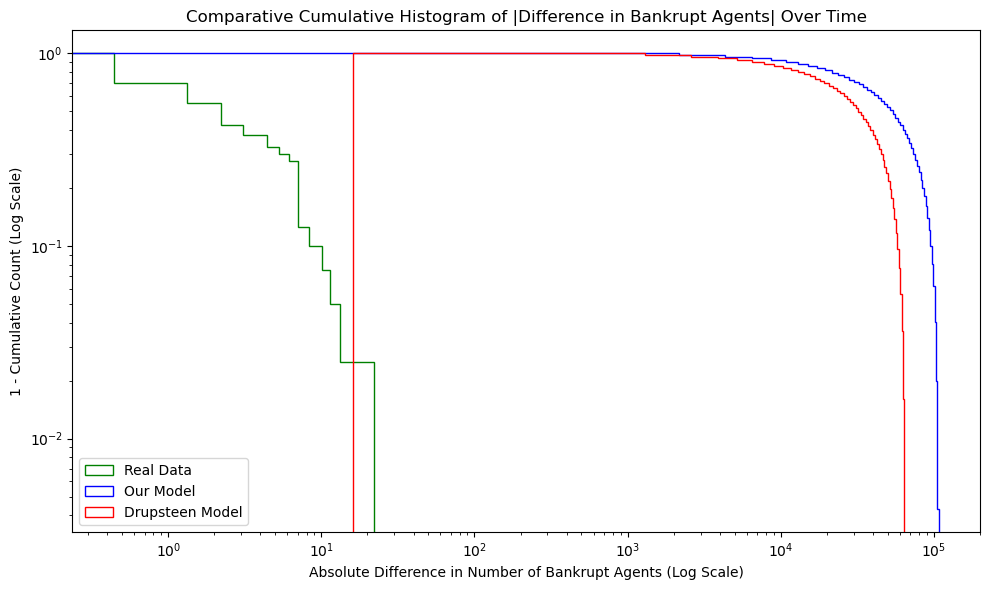

In [126]:
# Plot the real data cumulative histogram
plt.figure(figsize=(10, 6))
plt.hist(bankruptcy_data, bins=50, cumulative=-1, log=True, color='green', label='Real Data', histtype='step', density=True)

result_real_vs_ours = ks_2samp(bankruptcy_data, np.abs(adjusted_model_data))
print('KS Test Result (Real vs Our Model):', result_real_vs_ours)
alpha = 0.05  # significance level
if result_real_vs_ours.pvalue < alpha:
    print(f'Real vs Our Model: Reject H0. There is a significant difference between the distributions (p = {result_real_vs_ours.pvalue:.3f}) at an alpha level of {alpha}.')
else:
    print(f'Real vs Our Model: Fail to reject H0. There is no significant difference between the distributions (p = {result_real_vs_ours.pvalue:.3f}) at an alpha level of {alpha}.')

# Plot the model data cumulative histogram
plt.hist(np.abs(adjusted_model_data), bins=50, cumulative=-1, log=True, color='blue', label='Our Model', histtype='step', density=True)

result_real_vs_paper = ks_2samp(bankruptcy_data, np.abs(adjusted_paper_data))
print('KS Test Result (Real vs Drupsteen Model):', result_real_vs_paper)
if result_real_vs_paper.pvalue < alpha:
    print(f'Real vs Drupsteen Model: Reject H0. There is a significant difference between the distributions (p = {result_real_vs_paper.pvalue:.3f}) at an alpha level of {alpha}.')
else:
    print(f'Real vs Drupsteen Model: Fail to reject H0. There is no significant difference between the distributions (p = {result_real_vs_paper.pvalue:.3f}) at an alpha level of {alpha}.')

# Plot the paper data cumulative histogram
plt.hist(np.abs(adjusted_paper_data), bins=50, cumulative=-1, log=True, color='red', label='Drupsteen Model', histtype='step', density=True)

# Add labels and title
plt.xscale('log')
plt.xlabel('Absolute Difference in Number of Bankrupt Agents (Log Scale)')
plt.ylabel('1 - Cumulative Count (Log Scale)')
plt.title('Comparative Cumulative Histogram of |Difference in Bankrupt Agents| Over Time')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Results reveal that neither model fit this dataset using these parameters, however with a different dataset, different parameters or some scaled version of them the fit might improve. We leave this to future researchers